In [1]:
# Data manipulation and computation libraries
import pandas as pd
from math import sqrt

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Time series analysis and modeling libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Machine learning libraries
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Forecasting libraries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

### Initial Data Inspection

Upon importing the dataset into a new Python environment for advanced forecasting, an initial inspection of the data is conducted. 

In [2]:
df = pd.read_csv("../Data/part-00000-0e8a1681-97e4-4ef5-8685-de237d01ead3-c000.csv")

In [3]:
df.head()

,Date,average_sentiment
0,2009-06-23,-0.022575
1,2009-04-18,0.112916
2,2009-05-04,0.107951
3,2009-06-20,-0.014954
4,2009-05-27,0.102793


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               41 non-null     object 
 1   average_sentiment  41 non-null     float64
dtypes: float64(1), object(1)
memory usage: 784.0+ bytes


**Observation on number of records:**
- A preliminary assessment reveals that the dataset encompasses a relatively short time range. This aspect is critical to consider, especially when planning to conduct weekly, monthly, and quarterly forecasts.

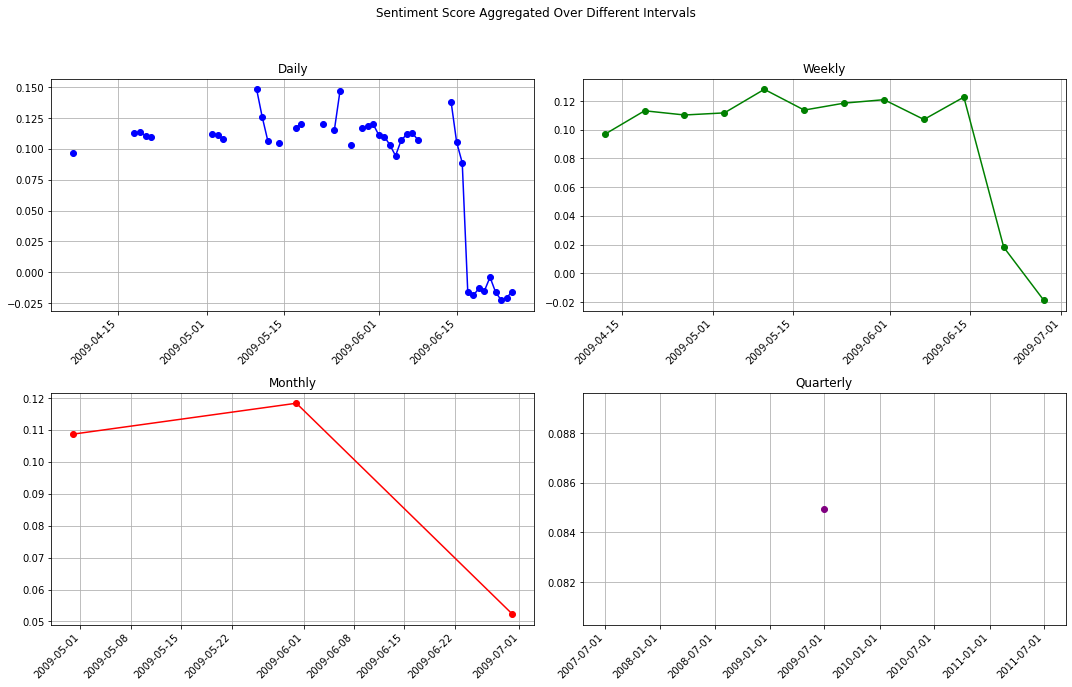

In [5]:
# Converting 'Date' column to datetime and setting it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resampling data into different time intervals
daily_data = df.resample('D').mean()
weekly_data = df.resample('W').mean()
monthly_data = df.resample('M').mean()
quarterly_data = df.resample('Q').mean()

# Plotting sentiment scores over different time intervals
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sentiment Score Aggregated Over Different Intervals')

# Plot settings for each time interval
time_intervals = [('Daily', daily_data, 'blue'), ('Weekly', weekly_data, 'green'), 
                  ('Monthly', monthly_data, 'red'), ('Quarterly', quarterly_data, 'purple')]
for ax, (title, data, color) in zip(axes.flatten(), time_intervals):
    ax.plot(data.index, data['average_sentiment'], marker='o', linestyle='-', color=color)
    ax.set_title(title)
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Forecast Feasibility Analysis from Resampled Sentiment Data

After visualizing the sentiment scores over daily, weekly, monthly, and quarterly intervals, the following observations are made:

- **Daily and Weekly Forecasting**: The data seems adequate for conducting daily forecasts and, to a lesser extent, weekly forecasts. The finer granularity of daily data allows for a more detailed trend analysis.

- **Limitations in Longer Intervals**: For monthly and quarterly forecasting, the dataset's short time span becomes a significant limitation. The lack of extensive historical data may result in less accurate predictions over these longer periods.

- **Concerns with Weekly Forecasts**: While weekly forecasting is possible, the brevity of the dataset raises concerns about the accuracy of such forecasts. The limited data points available for training could hinder the model's ability to learn robust patterns, potentially affecting forecast reliability.

While short-term forecasting (daily and weekly) is feasible with the current dataset, for longer-term predictions due to the dataset's limited time range pattern recognition could be not possible.

### Preparing for Effective Weekly Forecast Analysis

First goal is to effectively conducting a weekly sentiment forecast and analyzing the results. A key observation from the daily sentiment plots is the presence of missing data, indicated by blank spaces in the graph.

- **Data Gaps Identification**: The daily plots reveal some missing days of information, which could significantly impact the accuracy of weekly aggregations.

- **Impact Assessment of Data Filling**: The influence of this data filling strategy is to be evaluated by contrasting the weekly sentiment aggregation results before and after filling the missing values. This comparison is crucial to determine the effect of the data completion on the overall sentiment trends and the reliability of the forecast.

This approach is aimed at reinforcing the dataset's completeness, thereby enhancing the foundation for a robust and accurate weekly sentiment forecast.

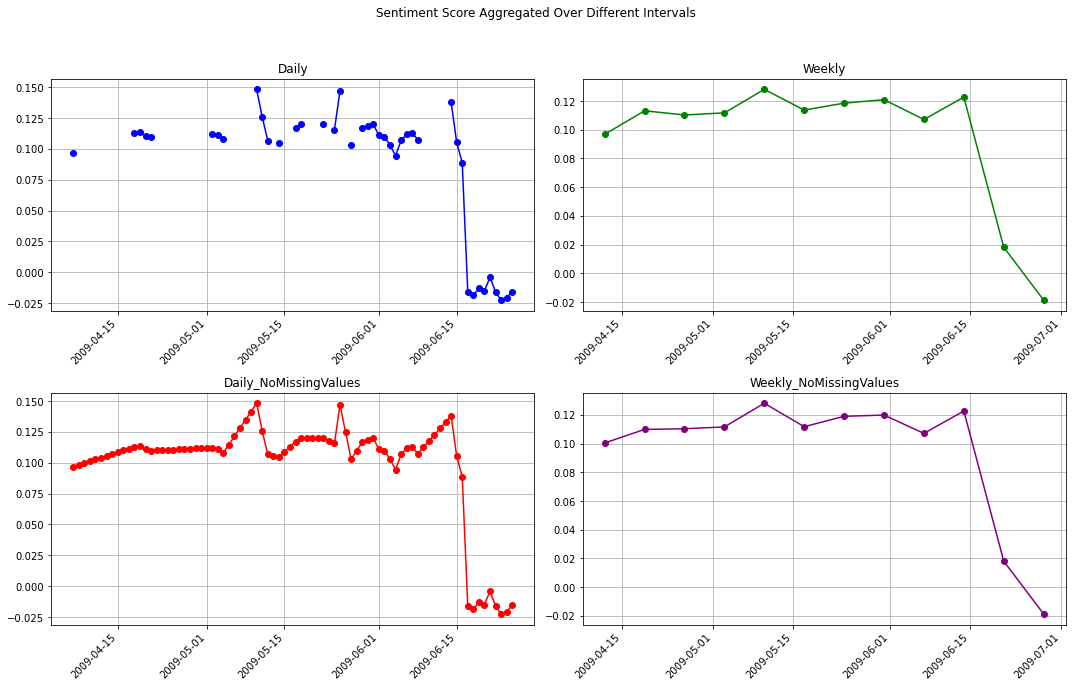

In [6]:
# Interpolating missing values in daily data
agg_daily = daily_data.copy()
agg_daily['average_sentiment'] = agg_daily['average_sentiment'].interpolate(method='linear')

# Resampling data for weekly aggregation
agg_weekly = agg_daily.resample('W').mean()

# Plotting sentiment scores over different time intervals with and without missing values
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sentiment Score Aggregated Over Different Intervals')

# Plot settings for each time interval
plot_data = [('Daily', daily_data, 'blue'), ('Weekly', weekly_data, 'green'),
             ('Daily_NoMissingValues', agg_daily, 'red'), ('Weekly_NoMissingValues', agg_weekly, 'purple')]
for ax, (title, data, color) in zip(axes.flatten(), plot_data):
    ax.plot(data.index, data['average_sentiment'], marker='o', linestyle='-', color=color)
    ax.set_title(title)
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analysis of Weekly Aggregation Robustness

Upon comparing the sentiment scores aggregated over different time intervals, it becomes evident that:

- **Impact of Missing Values on Daily Data**: The interpolation of missing daily values reveals a smoother trend in sentiment scores, particularly in the 'Daily_NoMissingValues' plot. This indicates that linear interpolation can effectively fill gaps in daily data.

- **Weekly Aggregation Resilience**: However, when observing the weekly aggregated data ('Weekly' vs. 'Weekly_NoMissingValues'), there appears to be minimal impact from the missing daily values. The weekly aggregation inherently smooths out these gaps, indicating a robustness in capturing overall weekly trends.

- **Project Focus on Weekly Forecast**: Given the project's emphasis on weekly forecasting, the resilience of weekly aggregation suggests that it's feasible to proceed with the original weekly data without needing to interpolate daily values. This approach maintains the authenticity of the original data while still providing reliable weekly insights.


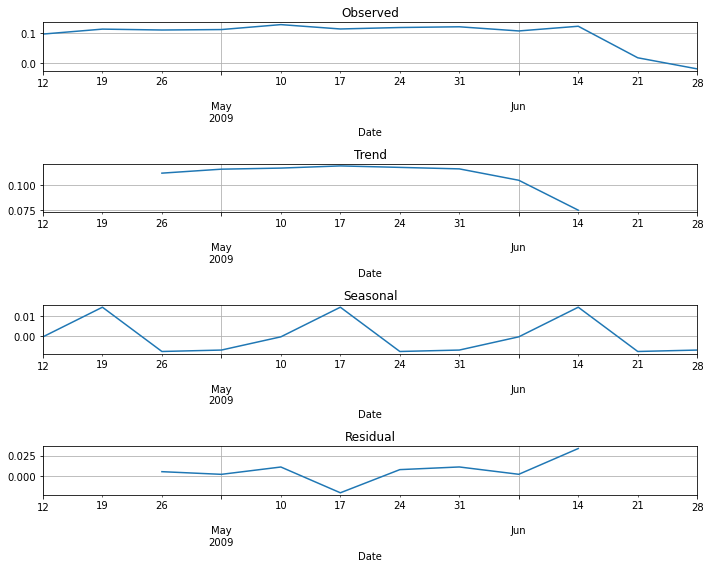

In [7]:
# Decompose the weekly aggregated sentiment data
result = sm.tsa.seasonal_decompose(weekly_data['average_sentiment'], model='additive', period=4)

# Plotting the decomposition results
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')

for ax in axes:
    ax.set_ylabel('')
    ax.grid(True)

plt.tight_layout()
plt.show()

### Insights from Weekly Data Decomposition

The decomposition of the weekly aggregated sentiment data reveals several key insights:

- **Negative Trend**: The trend component shows a downward trajectory over time, indicating a negative trend in the average sentiment.

- **Weekly Seasonality**: A distinct weekly seasonal pattern is observed in the data. This regular fluctuation aligns with the assumed weekly cycle in sentiment variations.

- **Unstructured Residuals**: The residuals, representing the part of the data not explained by the trend or seasonality, do not exhibit any specific pattern. This absence of structure in the residuals suggests that the decomposition has effectively captured the main systematic components in the time series.

Overall, the decomposition highlights both the negative trend and the weekly seasonality in the data, providing valuable insights for further analysis and forecasting endeavors.

### Assessing Stationarity with Augmented Dickey-Fuller Test

The next step in the time series analysis involves applying the Augmented Dickey-Fuller (ADF) Test to the weekly aggregated sentiment data. This test is critical for determining whether the dataset is stationary.

- **Importance of Stationarity**: Stationarity implies that the statistical properties of the time series (mean, variance, autocorrelation, etc.) are constant over time. Non-stationary data can lead to unreliable and misleading models.

- **Implications for Forecasting**: The results of the ADF Test will guide the subsequent steps in the forecasting process, including the need for any data transformation or differencing to achieve stationarity.

In [8]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on weekly data
adf_test = adfuller(weekly_data['average_sentiment'])

# Displaying the results
print('ADF Statistic: {:.6f}'.format(adf_test[0]))
print('p-value: {:.6f}'.format(adf_test[1]))
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t{}: {:.3f}'.format(key, value))

# Interpretation based on p-value
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary and may need differencing.")

ADF Statistic: 0.770094
p-value: 0.991138
Critical Values:
	1%: -4.332
	5%: -3.233
	10%: -2.749
The series is not stationary and may need differencing.


### Results of the Augmented Dickey-Fuller Test

The application of the Augmented Dickey-Fuller test to the weekly sentiment data yields the following results:

- **ADF Statistic and p-value**: The ADF statistic and its corresponding p-value are pivotal in determining the stationarity of the series. A low p-value (below 0.05) suggests that the null hypothesis of non-stationarity can be rejected.

- **Stationarity Confirmation**: Given that the p-value is below the threshold, it is concluded that the weekly sentiment series is stationary. This indicates that the statistical properties of the series, such as its mean and variance, do not change over time.

In [9]:
weekly_data_diff = weekly_data.diff().dropna()

In [10]:
# Perform Augmented Dickey-Fuller test on weekly data
adf_test = adfuller(weekly_data_diff['average_sentiment'])

# Displaying the results
print('ADF Statistic: {:.6f}'.format(adf_test[0]))
print('p-value: {:.6f}'.format(adf_test[1]))
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t{}: {:.3f}'.format(key, value))

# Interpretation based on p-value
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary and may need differencing.")

ADF Statistic: 1.795640
p-value: 0.998340
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
The series is not stationary and may need differencing.


In [11]:
weekly_data_diff2 = weekly_data_diff.diff().dropna()

In [12]:
# Perform Augmented Dickey-Fuller test on weekly data
adf_test = adfuller(weekly_data_diff2['average_sentiment'])

# Displaying the results
print('ADF Statistic: {:.6f}'.format(adf_test[0]))
print('p-value: {:.6f}'.format(adf_test[1]))
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t{}: {:.3f}'.format(key, value))

# Interpretation based on p-value
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary and may need differencing.")

ADF Statistic: -1.334287
p-value: 0.613344
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
The series is not stationary and may need differencing.


In [13]:
weekly_data_diff3 = weekly_data_diff2.diff().dropna()

In [14]:
# Perform Augmented Dickey-Fuller test on weekly data
adf_test = adfuller(weekly_data_diff3['average_sentiment'])

# Displaying the results
print('ADF Statistic: {:.6f}'.format(adf_test[0]))
print('p-value: {:.6f}'.format(adf_test[1]))
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t{}: {:.3f}'.format(key, value))

# Interpretation based on p-value
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary and may need differencing.")

ADF Statistic: -4.399897
p-value: 0.000297
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
The series is stationary.


In [15]:
weekly_data_diff3.head()

,average_sentiment
Date,
2009-05-03,0.023748
2009-05-10,0.010541
2009-05-17,-0.045780
2009-05-24,0.050122
2009-05-31,-0.021701


### Achieving Stationarity Through Differencing

In the process of preparing the dataset for time series analysis, it was found necessary to apply differencing three times to achieve stationarity. This step is critical to ensure the dataset's suitability for accurate forecasting models.

- **Necessity of Multiple Differencing**: The need to perform differencing three times indicates significant non-stationarity in the original dataset. Each round of differencing helps in removing trends and seasonal components, bringing the data closer to stationarity.

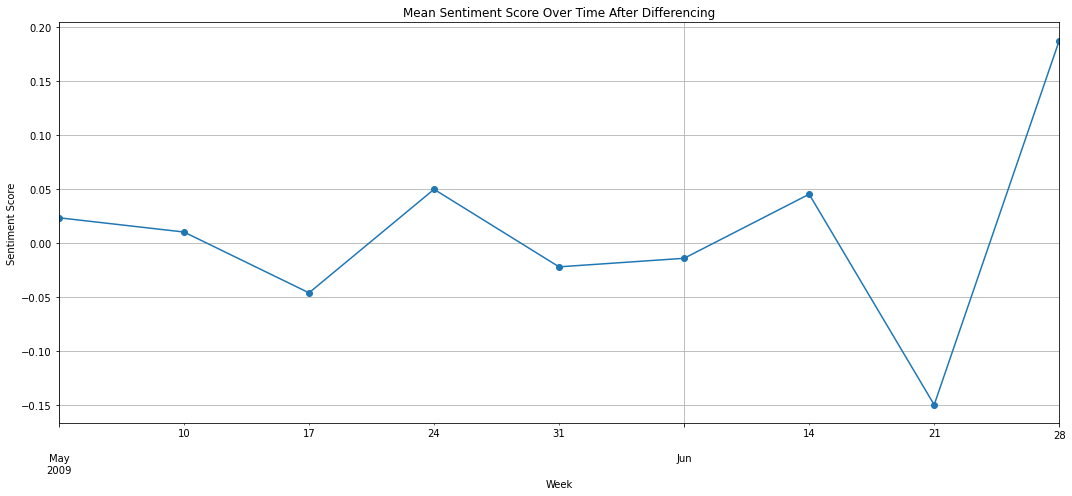

In [16]:
# Plotting the differenced weekly data
fig, ax = plt.subplots(figsize=(15, 7))
weekly_data_diff3['average_sentiment'].plot(ax=ax, marker='o', linestyle='-')
ax.set_title('Mean Sentiment Score Over Time After Differencing')
ax.set_xlabel('Week')
ax.set_ylabel('Sentiment Score')
ax.grid(True)
plt.tight_layout()
plt.show()

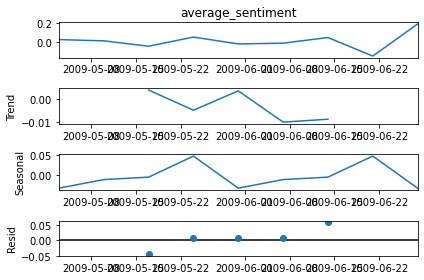

In [17]:
# Decomposing the differenced series
result = sm.tsa.seasonal_decompose(weekly_data_diff3['average_sentiment'], model='additive', period=4)

# Plotting the decomposition results
result.plot()
plt.show()

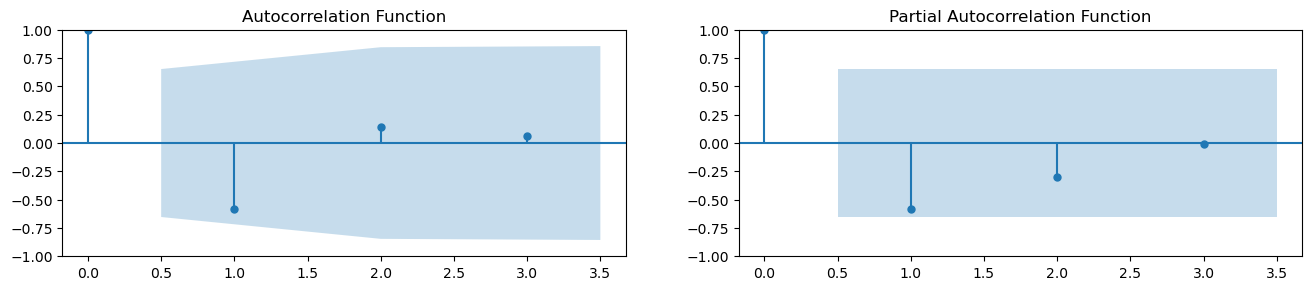

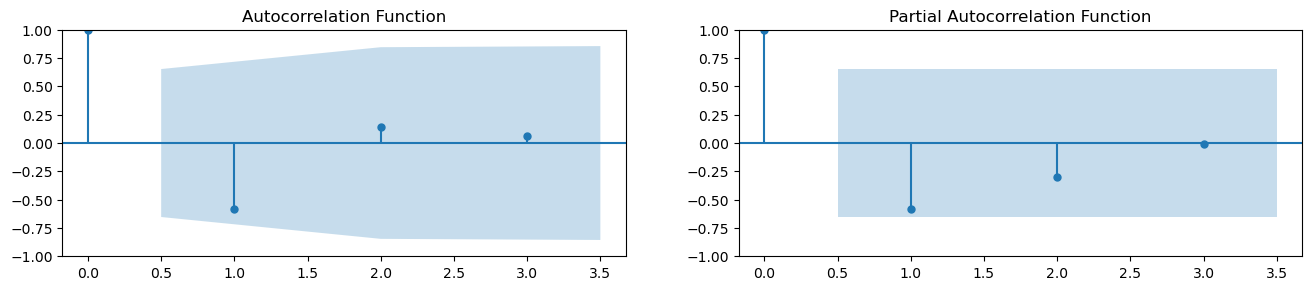

In [18]:
# Plotting ACF and PACF
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(weekly_data_diff3['average_sentiment'], lags=3, ax=axes[0], title='Autocorrelation Function')
plot_pacf(weekly_data_diff3['average_sentiment'], lags=3, ax=axes[1], method='ywm', title='Partial Autocorrelation Function')

### Interpreting ACF and PACF Plots

The analysis of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for the differenced weekly sentiment data provides valuable insights into the underlying process:

- **ACF Analysis**: The significant spike at lag 1 in the ACF plot, followed by a cutoff, suggests that a Moving Average (MA) process might be present, indicative of an MA(1) component in the time series.

- **PACF Analysis**: Similarly, the PACF plot shows a significant spike at lag 1, with no significant spikes afterward. This pattern is characteristic of an Autoregressive (AR) process, pointing towards an AR(1) component.

- **ARIMA Model Parameters**: Based on these observations, an ARIMA(1,3,1) model could be a fitting choice for the time series. Here, '1' denotes the order of the AR part, '3' indicates the differencing order necessary to achieve stationarity, and '1' represents the order of the MA part.

In [81]:
# Calculate the split point for an 80/20 train/test split
split_point = int(len(weekly_data) * 0.8)

# Split the data into training and test sets based on the calculated split point
train = weekly_data.iloc[:split_point]
test = weekly_data.iloc[split_point:]

# Displaying the size of training and test sets for verification
print("Training set size:", len(train))
print("Test set size:", len(test))

Training set size: 9
Test set size: 3


### ARIMA (Autoregressive Integrated Moving Average):
 - Strength in Short-Term Forecasts: ARIMA is particularly effective for short-range, non-seasonal time series data, making it suitable for your 12-week dataset.

In [82]:
# Defining and fitting the ARIMA model
model = ARIMA(train['average_sentiment'], order=(1, 3, 1))  # ARIMA(p, d, q)
model_fit = model.fit()

# In-sample prediction
in_sample_pred = model_fit.predict(start=train.index[0], end=train.index[-1], typ='levels')

# Out-of-sample prediction
out_of_sample_pred = model_fit.get_forecast(steps=len(test))
forecast = out_of_sample_pred.predicted_mean

# Calculate the root mean squared error
rmse = sqrt(mean_squared_error(test['average_sentiment'], forecast))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.061


C:\Users\rmora\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


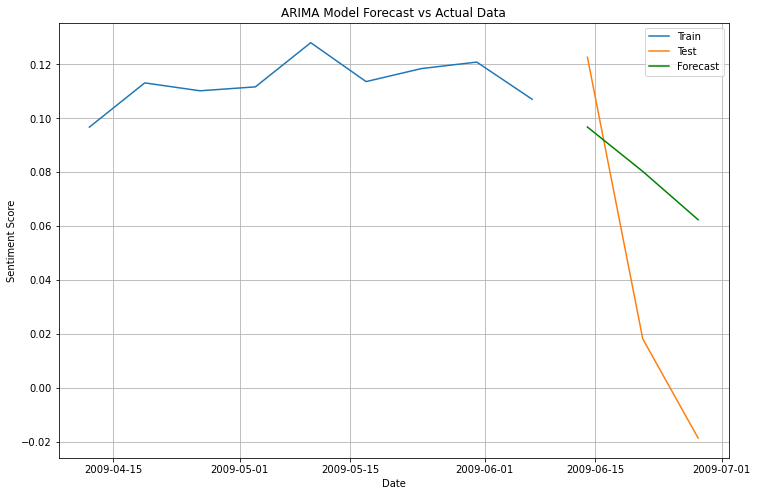

In [83]:
# Plotting the training data, test data, and forecast
plt.figure(figsize=(12, 8))
plt.plot(train['average_sentiment'], label='Train')
plt.plot(test['average_sentiment'], label='Test')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title('ARIMA Model Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### ForecasterAutoreg:

This model extends traditional autoregressive approaches by incorporating additional regressors. In the context of sentiment scores, it can use previous weeks' data to predict future scores, potentially capturing the hifts in public opinion reflected in tweets. 

In [25]:
data_test = data[:-split_point]
data_train  = data[-split_point:]

In [26]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 3
                )

forecaster.fit(y=data_train['average_sentiment'])
forecaster

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=123)
Lags: [1 2 3]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

In [31]:
steps = 3
predictions = forecaster.predict(steps=steps)
predictions_series = pd.Series(predictions, index=test.index)
predictions_series

Date
2009-06-14    0.045025
2009-06-21    0.018456
2009-06-28    0.018456
Freq: W-SUN, dtype: float64

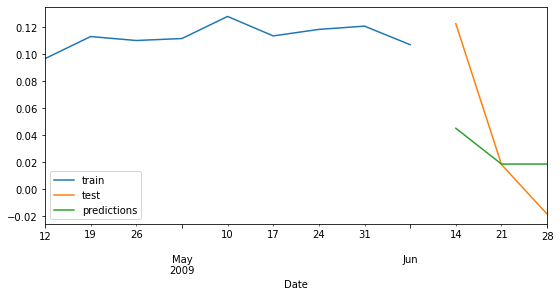

In [32]:
fig, ax = plt.subplots(figsize=(9, 4))
train['average_sentiment'].plot(ax=ax, label='train')
test['average_sentiment'].plot(ax=ax, label='test')
predictions_series.plot(ax=ax, label='predictions')
ax.legend();

In [33]:
error_mse = mean_squared_error(
                y_true = data_test['average_sentiment'],
                y_pred = predictions_series
            )
rmse = sqrt(error_mse)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.081


In [34]:
# Hyperparameter Grid search

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=3 
)

# Regressor's hyperparameters
param_grid = {'n_estimators': [10, 20, 30],
              'max_depth': [3, 5],
              'min_samples_split': [2, 4]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['average_sentiment'],
                        param_grid         = param_grid,
                        steps              = steps,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.7),
                        return_best        = True,
                        verbose            = False
               )

2023-11-16 07:04:27,508 root       INFO  Number of models compared: 12
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]
2023-11-16 07:04:27,837 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [1 2 3] 
params: {'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 30}



In [35]:
results_grid

,lags,params,metric,max_depth,min_samples_split,n_estimators
5,"[1, 2, 3]","{'max_depth': 3, 'min_samples_split': 4, 'n_es...",0.009022,3,4,30
11,"[1, 2, 3]","{'max_depth': 5, 'min_samples_split': 4, 'n_es...",0.009022,5,4,30
0,"[1, 2, 3]","{'max_depth': 3, 'min_samples_split': 2, 'n_es...",0.009049,3,2,10
6,"[1, 2, 3]","{'max_depth': 5, 'min_samples_split': 2, 'n_es...",0.009049,5,2,10
3,"[1, 2, 3]","{'max_depth': 3, 'min_samples_split': 4, 'n_es...",0.009078,3,4,10
9,"[1, 2, 3]","{'max_depth': 5, 'min_samples_split': 4, 'n_es...",0.009078,5,4,10
4,"[1, 2, 3]","{'max_depth': 3, 'min_samples_split': 4, 'n_es...",0.009080,3,4,20
10,"[1, 2, 3]","{'max_depth': 5, 'min_samples_split': 4, 'n_es...",0.009080,5,4,20
1,"[1, 2, 3]","{'max_depth': 3, 'min_samples_split': 2, 'n_es...",0.009153,3,2,20
7,"[1, 2, 3]","{'max_depth': 5, 'min_samples_split': 2, 'n_es...",0.009153,5,2,20


In [36]:
regressor = RandomForestRegressor(max_depth=3, n_estimators=30, min_samples_split=4, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 3
             )

forecaster.fit(y=data_train['average_sentiment'])

In [37]:
steps = 3
predictions = forecaster.predict(steps=steps)
predictions_series = pd.Series(predictions, index=test.index)
predictions_series

Date
2009-06-14    0.054490
2009-06-21    0.041823
2009-06-28    0.041823
Freq: W-SUN, dtype: float64

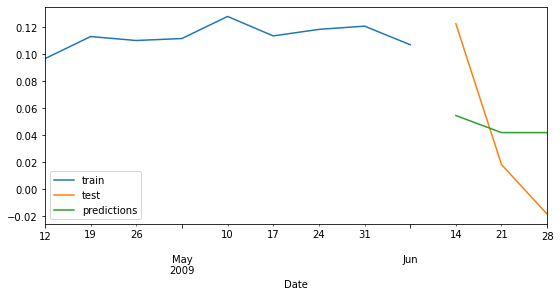

In [38]:
# Plot
fig, ax = plt.subplots(figsize=(9, 4))
train['average_sentiment'].plot(ax=ax, label='train')
test['average_sentiment'].plot(ax=ax, label='test')
predictions_series.plot(ax=ax, label='predictions')
ax.legend();

In [39]:
error_mse = mean_squared_error(
                y_true = data_test['average_sentiment'],
                y_pred = predictions_series
            )
rmse = sqrt(error_mse)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.062


### Prophet (by Facebook):
- Ease of Use: It requires less statistical expertise to tune compared to ARIMA, making it a practical choice for quick implementation.

In [46]:
Prophet_train = weekly_data.reset_index().rename(columns={'Date': 'ds', 'average_sentiment': 'y'})

In [56]:
# Splitting the dataset into train and test sets
split_date = '2009-06-21'  # Replace with your split date
train = Prophet_train[Prophet_train['ds'] <= split_date]
test = Prophet_train[Prophet_train['ds'] > split_date]

In [57]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(train)

# Make a future DataFrame for predictions
future = model.make_future_dataframe(periods=len(test), freq='W')
forecast = model.predict(future)

# Extract predicted values for the test set duration
forecasted_values = forecast['yhat'][-len(test):]

# Calculate error metrics
mse = mean_squared_error(test['y'], forecasted_values)
print(f'Mean Squared Error: {mse}')
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

2023-11-16 07:37:41,115 cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
2023-11-16 07:37:41,202 cmdstanpy  DEBUG TBB already found in load path
2023-11-16 07:37:41,209 prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2023-11-16 07:37:41,210 prophet    INFO  Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2023-11-16 07:37:41,210 prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-11-16 07:37:41,226 prophet    INFO  n_changepoints greater than number of observations. Using 7.
2023-11-16 07:37:41,230 cmdstanpy  DEBUG input tempfile: C:\Users\rmora\AppData\Local\Temp\tmpz_bb861y\deuf35f1.json
2023-11-16 07:37:41,233 cmdstanpy  DEBUG input tempfile: C:\Users\rmora\AppData\Local\Temp\tmpz_bb861y\sy1xg35v.json
2023-11-16 07:37:41,236 cmdstanpy  DEBUG idx 0
2023-11-16 07:37:41,237 cmdstanpy  DEBUG running CmdStan, num_threads: None
2023-11

Mean Squared Error: 0.011001364576425738
Test RMSE: 0.105


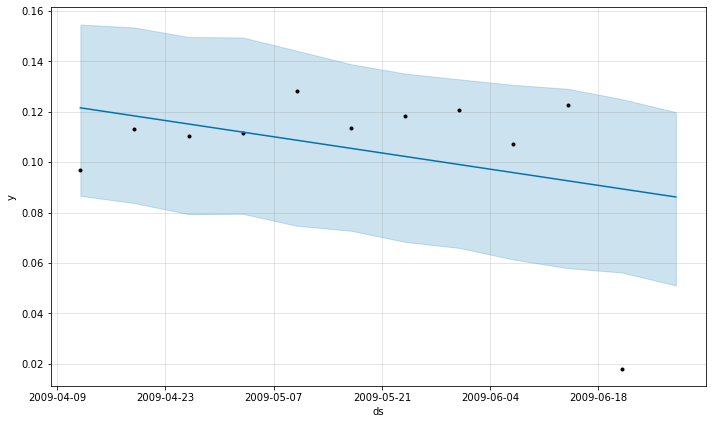

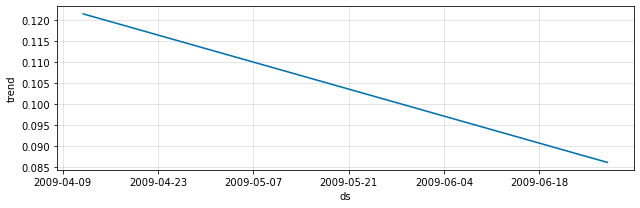

In [58]:
# Plotting the results
import matplotlib.pyplot as plt
fig1 = model.plot(forecast)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

In [66]:
Prophet_train = agg_daily.reset_index().rename(columns={'Date': 'ds', 'average_sentiment': 'y'})

In [67]:
# Splitting the dataset into train and test sets
split_point = int(len(Prophet_train) * 0.8)
train = Prophet_train.iloc[:split_point]
test = Prophet_train.iloc[split_point:]

In [68]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(train)

# Make a future DataFrame for predictions
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)

# Extract predicted values for the test set duration
forecasted_values = forecast['yhat'][-len(test):]

# Calculate error metrics
mse = mean_squared_error(test['y'], forecasted_values)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

2023-11-16 07:45:53,128 cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
2023-11-16 07:45:53,216 cmdstanpy  DEBUG TBB already found in load path
2023-11-16 07:45:53,221 prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2023-11-16 07:45:53,222 prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-11-16 07:45:53,241 cmdstanpy  DEBUG input tempfile: C:\Users\rmora\AppData\Local\Temp\tmpz_bb861y\9fn57teu.json
2023-11-16 07:45:53,248 cmdstanpy  DEBUG input tempfile: C:\Users\rmora\AppData\Local\Temp\tmpz_bb861y\euoveg13.json
2023-11-16 07:45:53,251 cmdstanpy  DEBUG idx 0
2023-11-16 07:45:53,253 cmdstanpy  DEBUG running CmdStan, num_threads: None
2023-11-16 07:45:53,254 cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\rmora\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=49308', 'data', 'file=C:\\Users\\rmora\\AppData\\Local\\Temp\\tmpz_bb861y\\9

Test RMSE: 0.093


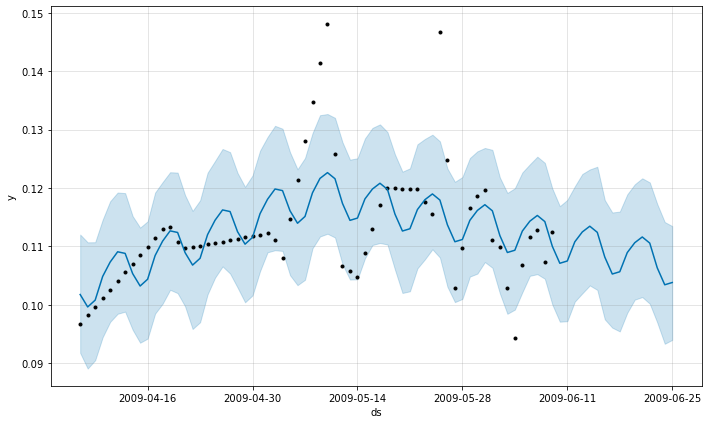

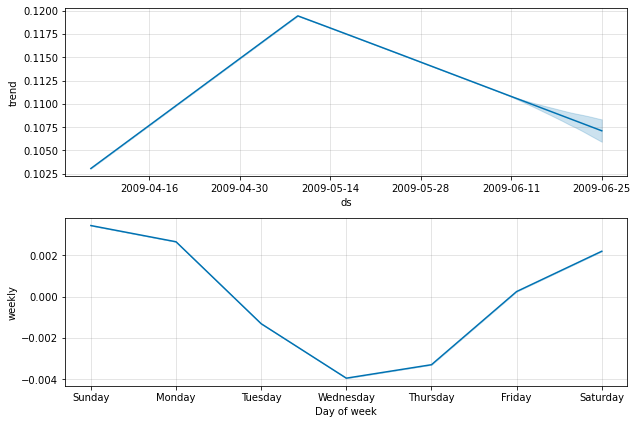

In [69]:
# Plotting the results (optional)
import matplotlib.pyplot as plt
fig1 = model.plot(forecast)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

### Monthly forescast

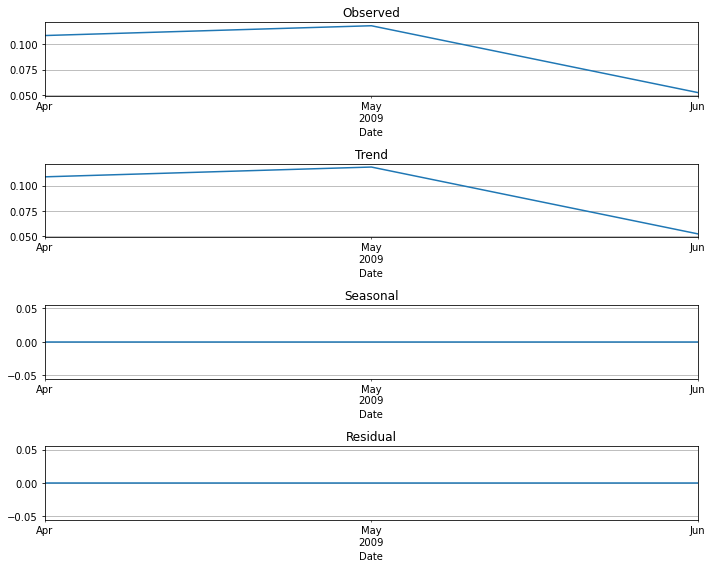

In [71]:
# Decompose the weekly aggregated sentiment data
result = sm.tsa.seasonal_decompose(monthly_data['average_sentiment'], model='additive', period=1)

# Plotting the decomposition results
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')

for ax in axes:
    ax.set_ylabel('')
    ax.grid(True)

plt.tight_layout()
plt.show()

### Analysis of Weekly Forecast Accuracy and Implications

The results from the weekly forecast reveal several key insights about the dataset's limitations and the forecast's accuracy:

- **Limited Dataset Size**: The short duration of the dataset poses a significant challenge in capturing long-term trends accurately. This limitation is particularly evident in the weekly forecast, where the prediction accuracy is not optimal.

- **Impact of Downward Trend**: The dataset exhibits a pronounced downward trend towards the end of the period. This trend significantly influences the model's predictions, leading to an overarching expectation of decreasing sentiment. Such a trend can skew the forecast, especially in the face of drastic changes.

- **Forecasting Longer Periods**: Despite the limitations in weekly forecast accuracy, the project requirements necessitate generating monthly and quarterly forecasts. To fulfill this, the existing model trained for weekly forecasts will be extended to predict 15 weeks ahead. These extended forecasts will provide an indicative trend for the upcoming months and quarter, albeit with the understanding that the predictions may not fully capture the potential variability and complexity of future sentiments.

- **Cautious Interpretation**: Given these constraints, it is crucial to interpret the monthly and quarterly forecasts cautiously. They should be viewed as indicative trends rather than precise predictions, especially considering the dataset's limited scope in representing long-term patterns.



In [84]:
out_of_sample_pred = model_fit.get_forecast(steps=15)
forecast = out_of_sample_pred.predicted_mean
forecast

2009-06-14    0.096735
2009-06-21    0.080263
2009-06-28    0.062341
2009-07-05    0.040675
2009-07-12    0.016387
2009-07-19   -0.011071
2009-07-26   -0.041433
2009-08-02   -0.074828
2009-08-09   -0.111192
2009-08-16   -0.150557
2009-08-23   -0.192908
2009-08-30   -0.238252
2009-09-06   -0.286586
2009-09-13   -0.337910
2009-09-20   -0.392225
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [74]:
weekly_data

,average_sentiment
Date,
2009-04-12,0.096715
2009-04-19,0.113132
2009-04-26,0.110197
2009-05-03,0.111658
2009-05-10,0.128056
2009-05-17,0.113611
2009-05-24,0.118445
2009-05-31,0.120856
2009-06-07,0.107063


In [80]:
# Save the data both actual and forecast
weekly_data.to_csv('actual_data.csv')
forecast.to_csv('forecast_data.csv')